This example uses matplotlib, cartopy, shapely, and python-awips to plot watch and warning polygons requested from a real-time AWIPS EDEX server.

First, set up our imports and define functions to be used later:

In [1]:
from awips.dataaccess import DataAccessLayer
from awips.tables import vtec
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.geometry import MultiPolygon,Polygon

def warning_color(phensig):
    return vtec[phensig]['color']

def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(20,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

Next, we create a request for the "warning" data type:

In [2]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("warning")
request.setParameters('phensig')
times = DataAccessLayer.getAvailableTimes(request)

# Get records for last 50 available times
response = DataAccessLayer.getGeometryData(request, times[-50:-1])
print("Using " + str(len(response)) + " records")

# Each record will have a numpy array the length of the number of "parameters"
# Default is 1 (request.setParameters('phensig'))
parameters = {}
for x in request.getParameters():
    parameters[x] = np.array([])
print(parameters)

Using 82 records
{'phensig': array([], dtype=float64)}


Now loop through each record and plot it as either Polygon or MultiPolygon, with appropriate colors

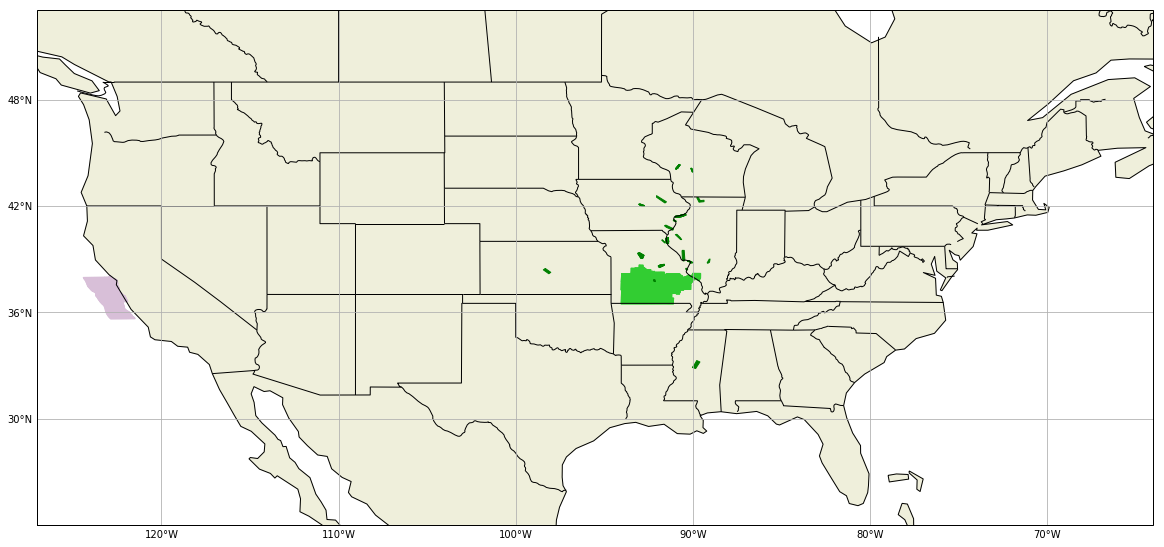

In [3]:
%matplotlib inline
bbox=[-127,-64,24,49]
fig, ax = make_map(bbox=bbox)

siteids=np.array([])
periods=np.array([])
reftimes=np.array([])

for ob in response:
    
    poly = ob.getGeometry()
    site = ob.getLocationName()
    pd   = ob.getDataTime().getValidPeriod()
    ref  = ob.getDataTime().getRefTime()
    
    # do not plot if phensig is blank (SPS)
    if ob.getString(b'phensig'):
        
        phensigString = ob.getString(b'phensig')
        
        siteids = np.append(siteids,site)
        periods = np.append(periods,pd)
        reftimes = np.append(reftimes,ref)

        for parm in parameters:
            byte_str = str.encode(parm)
            parameters[parm] = np.append(parameters[parm],ob.getString(byte_str))

        if poly.geom_type == 'MultiPolygon':
            geometries = np.array([])
            geometries = np.append(geometries,MultiPolygon(poly))
            geom_count = ", " + str(len(geometries)) +" geometries"
        else:
            geometries = np.array([])
            geometries = np.append(geometries,Polygon(poly))
            geom_count=""

        for geom in geometries:
            bounds = Polygon(geom)
            intersection = bounds.intersection
            geoms = (intersection(geom)
                 for geom in geometries
                 if bounds.intersects(geom))
    
        #print(vtec[phensigString]['hdln'] 
        #  + " (" + phensigString + ") issued at " + str(ref)
        #  + " ("+str(poly.geom_type) + geom_count + ")")
        
        color = warning_color(phensigString.decode('UTF-8'))
        shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor=color, edgecolor=color)
        ax.add_feature(shape_feature)
            
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
political_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(political_boundaries, edgecolor='black')

plt.show()